In [807]:
import pandas as pd
import numpy as np
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from IPython.display import Image
from sklearn import tree
import pydotplus
import os
from os import system
from sklearn.linear_model import LogisticRegression

In [808]:
shows = pd.read_csv('good_shows_data2.csv')

In [809]:
pd.set_option('max_seq_items', 200)

In [810]:
shows.shape

(2515, 168)

In [811]:
## dropping old shows
shows = shows[shows['release_date']>=1980]

In [812]:
## dropping shows where I don't know whether they were cancelled
shows = shows[shows['seasons'] != 0]

In [813]:
shows['release_date'] = shows['release_date'].dropna().apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
shows['release_month'] = shows['release_date'].dropna().apply(lambda x: x.strftime('%m'))
shows['release_month'] = shows['release_month'].dropna().apply(lambda x: int(x))
shows['release_weekday'] = shows['release_date'].dropna().apply(lambda x: x.strftime('%w'))
shows['release_weekday'] = shows['release_weekday'].dropna().apply(lambda x: int(x))

shows['started_sunday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==0 else 0)
shows['started_monday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==1 else 0)
shows['started_tuesday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==2 else 0)
shows['started_wednesday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==3 else 0)
shows['started_thursday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==4 else 0)
shows['started_friday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==5 else 0)
shows['started_saturday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==6 else 0)

In [814]:
shows.shape

(2061, 168)

In [815]:
shows.columns

Index([u'json', u'title_rough', u'check', u'title', u'imdb_id', u'big_json',
       u'seasons', u'cancelled', u'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords',
       u'first_year', u'is_new', u'fixed_runtime', u'is_action',
       u'is_adventure', u'is_animation', u'is_biography', u'is_comedy',
       u'is_crime', u'is_documentary', u'is_drama', u'is_family',
       u'is_fantasy', u'is_game', u'is_history', u'is_horror', u'is_music',
       u'is_musical', u'is_mystery', u'is_news', u'is_reality', u'is_romance',
       u'is_sci', u'is_short', u'is_sport', u'is_talk', u'is_thriller',
       u'is_war', u'is_western', u'release_month', u'release_weekday',
       u'release_monthday', u'stemmed_plot', u'stemmed_keywords',
       u'keyword_adult', u'keyword_african', u'keyword_alien',
       u'keyword_american', u'keyword_angel', u'keyword_anim', u'keyword_base',
       u'keyword_best', u'keyword_black', u'keyword_book', u'keywor

In [816]:
shows.dtypes

json                            object
title_rough                     object
check                            int64
title                           object
imdb_id                         object
big_json                        object
seasons                          int64
cancelled                        int64
runtime                         object
genres                          object
imdb_rating                    float64
release_date            datetime64[ns]
plot                            object
year                            object
type                            object
votes                           object
keywords                        object
first_year                       int64
is_new                           int64
fixed_runtime                  float64
is_action                        int64
is_adventure                     int64
is_animation                     int64
is_biography                     int64
is_comedy                        int64
is_crime                 

In [817]:
shows = shows.drop(['json', u'title_rough', u'check', u'title', 'imdb_id', u'big_json',
       u'seasons', 'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords', u'is_new', 
        'stemmed_plot', u'stemmed_keywords', 'plot_cleaned', u'network', 'release_month', 'release_weekday', 'fixed_runtime', 'keyword_new'], axis=1)

In [818]:
shows.shape

(2061, 143)

In [819]:
shows.columns

Index([u'cancelled', u'first_year', u'is_action', u'is_adventure',
       u'is_animation', u'is_biography', u'is_comedy', u'is_crime',
       u'is_documentary', u'is_drama', u'is_family', u'is_fantasy', u'is_game',
       u'is_history', u'is_horror', u'is_music', u'is_musical', u'is_mystery',
       u'is_news', u'is_reality', u'is_romance', u'is_sci', u'is_short',
       u'is_sport', u'is_talk', u'is_thriller', u'is_war', u'is_western',
       u'release_monthday', u'keyword_adult', u'keyword_african',
       u'keyword_alien', u'keyword_american', u'keyword_angel',
       u'keyword_anim', u'keyword_base', u'keyword_best', u'keyword_black',
       u'keyword_book', u'keyword_boy', u'keyword_boyfriend',
       u'keyword_brother', u'keyword_california', u'keyword_celebr',
       u'keyword_charact', u'keyword_child', u'keyword_citi',
       u'keyword_comedi', u'keyword_comedian', u'keyword_comic',
       u'keyword_cult', u'keyword_daughter', u'keyword_death',
       u'keyword_detect', u'keyw

In [820]:
shows.shape

(2061, 143)

In [821]:
shows.dropna().shape

(2061, 143)

In [822]:
## defining dependent/independent variables
y = shows['cancelled']
x = shows.drop('cancelled', axis=1)

In [823]:
## Base probability
y.mean()

0.39349830179524503

In [824]:
## train/test split
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [825]:
x_train.shape

(1545, 142)

In [826]:
x_test.shape

(516, 142)

In [827]:
y_train.shape

(1545,)

In [828]:
y_test.shape

(516,)

In [829]:
## runs model
def run_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    print "Training set score: ", model.score(x_train, y_train)
    print "Test set score: ", model.score(x_test, y_test)
    predictions = model.predict(x_test)
    print "\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n",classification_report(y_test, predictions)

In [830]:
## plots ROC curve
def plot_roc(x_test, y_test, model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Random Forest

In [831]:
rf = RandomForestClassifier()

In [832]:
run_model(x_train, y_train, x_test, y_test, rf)

Training set score:  0.981229773463
Test set score:  0.658914728682

Confusion Matrix:
      predicted_0  predicted_1
is_0          259           56
is_1          120           81

Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.82      0.75       315
          1       0.59      0.40      0.48       201

avg / total       0.65      0.66      0.64       516



In [833]:
rf.predict_proba(x_test)

array([[ 0.9,  0.1],
       [ 0.7,  0.3],
       [ 0.7,  0.3],
       ..., 
       [ 0.7,  0.3],
       [ 0.6,  0.4],
       [ 0.6,  0.4]])

ROC AUC: 0.70


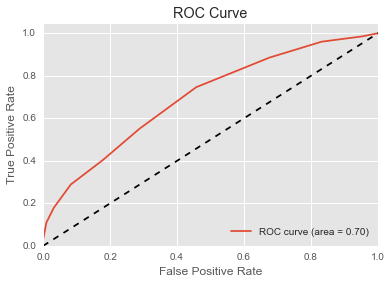

In [834]:
plot_roc(x_test, y_test, rf)

## Random Forest with grid search

In [835]:
parameters = {
    "n_estimators" : [10, 25, 50, 100],
    "max_depth" : [5,7,10,15],
    "max_features" : [0.25, 0.5, 0.75],
    "min_samples_leaf" : [2,4]
}

In [836]:
gs_rf = RandomForestClassifier()
grid_search = GridSearchCV(gs_rf,param_grid=parameters, cv=7, n_jobs=-1)

In [837]:
## 12:21 - 12:22
grid_search.fit(x_train, y_train)

GridSearchCV(cv=7, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 25, 50, 100], 'max_features': [0.25, 0.5, 0.75], 'max_depth': [5, 7, 10, 15], 'min_samples_leaf': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [838]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.5, max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [839]:
run_model(x_train, y_train, x_test, y_test, grid_search.best_estimator_)

Training set score:  0.941747572816
Test set score:  0.68023255814

Confusion Matrix:
      predicted_0  predicted_1
is_0          255           60
is_1          105           96

Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.81      0.76       315
          1       0.62      0.48      0.54       201

avg / total       0.67      0.68      0.67       516



ROC AUC: 0.70


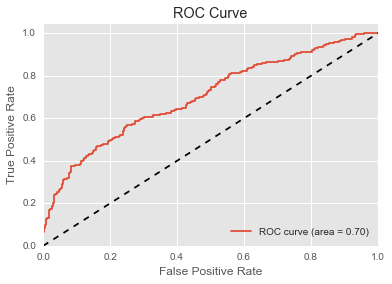

In [840]:
plot_roc(x_test, y_test, grid_search.best_estimator_)

In [841]:
grid_search.best_estimator_.predict_proba(x_test)

array([[ 0.76213938,  0.23786062],
       [ 0.54506901,  0.45493099],
       [ 0.57489574,  0.42510426],
       ..., 
       [ 0.73513295,  0.26486705],
       [ 0.47754634,  0.52245366],
       [ 0.86304411,  0.13695589]])

In [842]:
rf_feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
rf_feature_importances.head(20)

,importance
first_year,0.104360
release_monthday,0.091434
keyword_charact,0.044341
keyword_relationship,0.029965
started_september,0.025797
from_ABC,0.023220
keyword_fiction,0.022120
half_hour,0.020877
keyword_man,0.018225
is_comedy,0.017349


## Decision Tree

In [844]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [845]:
## tune hyperparameters here
dt = DecisionTreeClassifier(
    max_depth=15, 
    min_samples_leaf=4,
    max_leaf_nodes=8,
    criterion='gini'
)

In [846]:
run_model(x_train, y_train, x_test, y_test, dt)

Training set score:  0.631067961165
Test set score:  0.606589147287

Confusion Matrix:
      predicted_0  predicted_1
is_0          298           17
is_1          186           15

Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.95      0.75       315
          1       0.47      0.07      0.13       201

avg / total       0.56      0.61      0.51       516



ROC AUC: 0.57


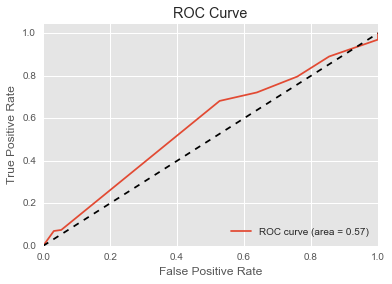

In [847]:
plot_roc(x_test, y_test, dt)

In [848]:
def tune_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    print "Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, new_predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n", classification_report(y_test, new_predictions)
    plt.hist(new_predictions)
    plt.xlabel('New Predictions')
    plt.ylabel('Frequency')
    plt.title('Distribution of New Predictions')
    plt.show()

Confusion Matrix:
      predicted_0  predicted_1
is_0          149          166
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.47      0.56       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.55      0.56       516



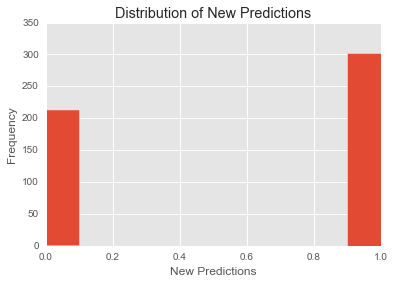

In [849]:
tune_predictions(dt, x_test, y_test, .30)

Confusion Matrix:
      predicted_0  predicted_1
is_0          305           10
is_1          187           14

Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.97      0.76       315
          1       0.58      0.07      0.12       201

avg / total       0.61      0.62      0.51       516



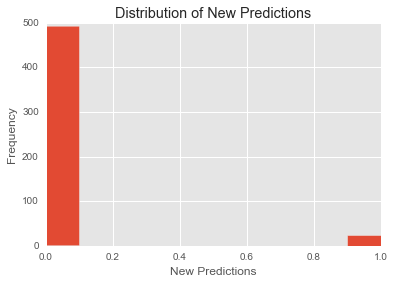

In [850]:
tune_predictions(dt, x_test, y_test, .60)

In [851]:
## plots the distribution of prediction probabilities for the 1 class
def plot_proba(x_test, model):
    predict = model.predict_proba(x_test)
    plt.hist(predict[:,1], bins=40)
    plt.ylabel('Frequency')
    plt.xlabel('Class 1 Probability Cutoff')
    plt.show()

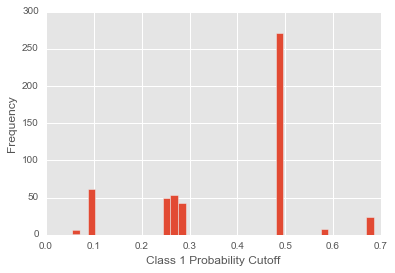

In [852]:
plot_proba(x_test, dt)

(array([   7.,    0.,  200.,   17.,   17.,  186.,    0.,    0.,    0.,   89.]),
 array([ 0.125     ,  0.17825342,  0.23150685,  0.28476027,  0.3380137 ,
         0.39126712,  0.44452055,  0.49777397,  0.5510274 ,  0.60428082,
         0.65753425]),
 <a list of 10 Patch objects>)

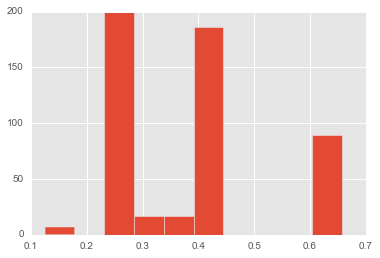

In [853]:
plt.hist(predict[:,1])

([array([   0.,    0.,   89.,    0.,    0.,  186.,   17.,   61.,  156.,    7.]),
  array([   7.,  156.,   61.,   17.,  186.,    0.,    0.,   89.,    0.,    0.])],
 array([ 0.125,  0.2  ,  0.275,  0.35 ,  0.425,  0.5  ,  0.575,  0.65 ,
         0.725,  0.8  ,  0.875]),
 <a list of 2 Lists of Patches objects>)

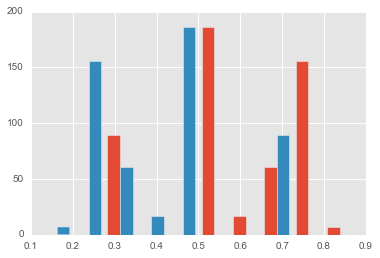

In [854]:
plt.hist(predict)

(array([ 427.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   89.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

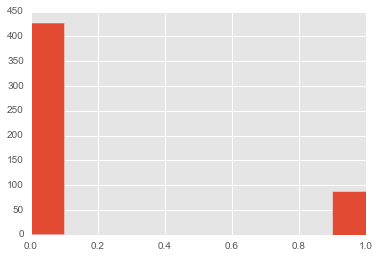

In [855]:
plt.hist(predictions_60)

In [856]:
predictions_60

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


In [857]:
confusion_matrix(y_test, predictions_60)

array([[253,  62],
       [174,  27]])

Confusion Matrix:
      predicted_0  predicted_1
is_0          149          166
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.47      0.56       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.55      0.56       516



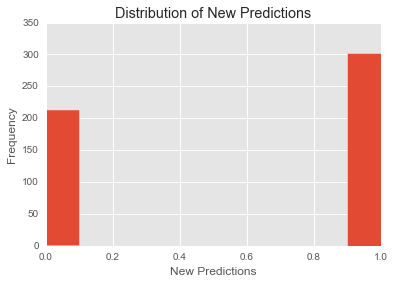

In [858]:
tune_predictions(dt, x_test, y_test, .30)

Confusion Matrix:
      predicted_0  predicted_1
is_0          149          166
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.47      0.56       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.55      0.56       516



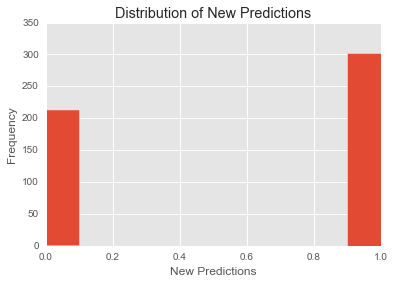

In [859]:
tune_predictions(dt, x_test, y_test, .40)

## grid-searching the decision tree

In [860]:
dt_for_gs = DecisionTreeClassifier()

In [861]:
params_dt = {
    "max_depth":[10,15,20],
    "min_samples_leaf":[2,3,4,5],
    "max_leaf_nodes":[4,6,8,10],
    "criterion":['gini', 'entropy']
}

In [862]:
gs_dt = GridSearchCV(dt_for_gs, params_dt)

In [863]:
gs_dt.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [4, 6, 8, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [864]:
gs_dt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [865]:
run_model(x_train, y_train, x_test, y_test, gs_dt.best_estimator_)

Training set score:  0.649190938511
Test set score:  0.624031007752

Confusion Matrix:
      predicted_0  predicted_1
is_0          293           22
is_1          172           29

Classification Report:
             precision    recall  f1-score   support

          0       0.63      0.93      0.75       315
          1       0.57      0.14      0.23       201

avg / total       0.61      0.62      0.55       516



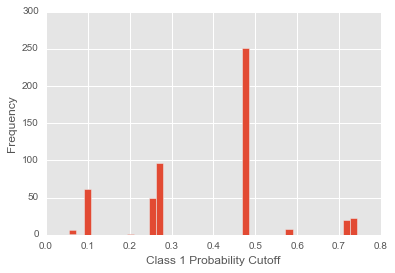

In [866]:
## in the original model, the false negatives were higher than the true positives. This is terrible, and needs fixing.


plot_proba(x_test, gs_dt.best_estimator_)

Confusion Matrix:
      predicted_0  predicted_1
is_0          150          165
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.48      0.57       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.56      0.56       516



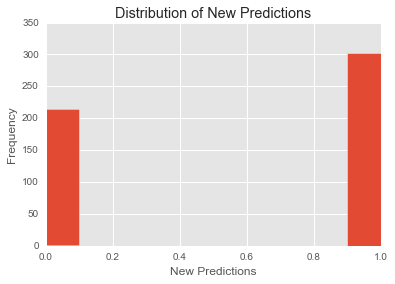

In [867]:
## with probability=0.4, model score is 0.62. the false negatives are down, but the false positives are up.
tune_predictions(gs_dt, x_test, y_test, .40)

In [868]:
confusion_matrix(y_test, predictions_60)

array([[253,  62],
       [174,  27]])

In [869]:
cmatrix = confusion_matrix(y_test, predictions_60)

In [870]:
cmatrix[0,0]

253

In [871]:
def get_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    return new_predictions

In [872]:
def find_optimal_probability(model, x_test, y_test):
    probabilities = range(1,101)
    new_probabilities = []
    for i in probabilities:
        new_probabilities.append(float(i)/100)
    range_of_scores = []
    for i in new_probabilities:
        new_preds = get_predictions(model, x_test, y_test, i)
        cmatrix = confusion_matrix(y_test, new_preds)
        new_model_score = (cmatrix[0,0] + cmatrix[1,1])/float(np.sum(cmatrix))
        range_of_scores.append(new_model_score)
    
    plt.plot(new_probabilities, range_of_scores)
    plt.title("Model Scores at Different Cutoff Probabilities")
    plt.xlabel("Probability Cutoff")
    plt.ylabel("Model Score")
    plt.show()

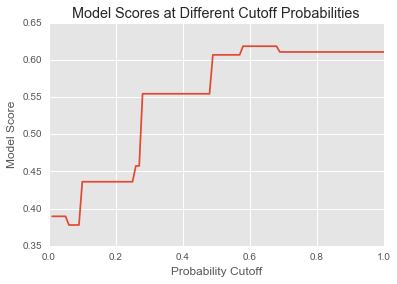

In [873]:
find_optimal_probability(dt, x_test, y_test)

## Gradient Boosting

In [875]:
GradientBoostingClassifier()

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [876]:
boost_default = GradientBoostingClassifier()

In [877]:
boost = GradientBoostingClassifier(
    n_estimators=500, 
    max_depth= 6,
    learning_rate= 0.1, 
    min_samples_leaf=2
    )

In [878]:
run_model(x_train, y_train, x_test, y_test, boost)

Training set score:  1.0
Test set score:  0.656976744186

Confusion Matrix:
      predicted_0  predicted_1
is_0          232           83
is_1           94          107

Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.74      0.72       315
          1       0.56      0.53      0.55       201

avg / total       0.65      0.66      0.66       516



In [879]:
run_model(x_train, y_train, x_test, y_test, boost_default)

Training set score:  0.794822006472
Test set score:  0.678294573643

Confusion Matrix:
      predicted_0  predicted_1
is_0          247           68
is_1           98          103

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.78      0.75       315
          1       0.60      0.51      0.55       201

avg / total       0.67      0.68      0.67       516



In [880]:
boost_feature_importances = pd.DataFrame(boost_default.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
boost_feature_importances.head(20)

,importance
first_year,0.124028
release_monthday,0.068787
from_ABC,0.035520
keyword_charact,0.034160
is_documentary,0.021511
keyword_fiction,0.021280
started_september,0.021012
keyword_friend,0.020070
keyword_cult,0.018948
full_hour,0.018384


## ADA Boosting

In [881]:
ada_boost = AdaBoostClassifier(n_estimators=100)

In [882]:
## gradient boost for reference
run_model(x_train, y_train, x_test, y_test, boost)

Training set score:  1.0
Test set score:  0.643410852713

Confusion Matrix:
      predicted_0  predicted_1
is_0          228           87
is_1           97          104

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.72      0.71       315
          1       0.54      0.52      0.53       201

avg / total       0.64      0.64      0.64       516



In [883]:
## ada boost
run_model(x_train, y_train, x_test, y_test, ada_boost)

Training set score:  0.726213592233
Test set score:  0.68023255814

Confusion Matrix:
      predicted_0  predicted_1
is_0          240           75
is_1           90          111

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.76      0.74       315
          1       0.60      0.55      0.57       201

avg / total       0.68      0.68      0.68       516



ROC AUC: 0.73


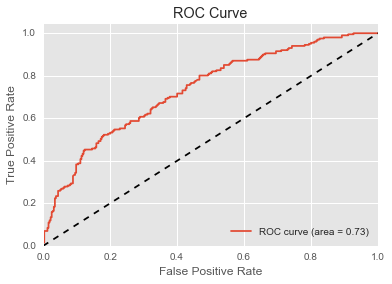

In [884]:
plot_roc(x_test, y_test, ada_boost)

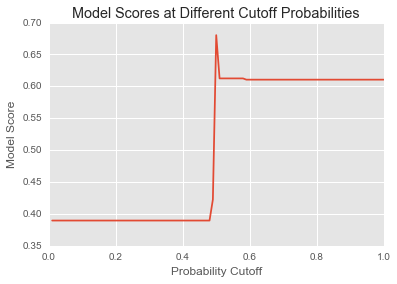

In [885]:
find_optimal_probability(ada_boost, x_test, y_test)

In [886]:
adaboost_feature_importances = pd.DataFrame(ada_boost.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
adaboost_feature_importances.head(20)

,importance
first_year,0.17
release_monthday,0.07
keyword_friend,0.03
is_game,0.02
half_hour,0.02
from_ABC,0.02
keyword_man,0.02
keyword_charact,0.02
is_talk,0.02
is_reality,0.02


## Decision tree for show

In [887]:
## this will create a single decision tree from the whole dataset that is readable by humans. 
## for display purposes only. it will be tuned to have approximately the same score as the AdaBoost model

dt_for_show = DecisionTreeClassifier(
                    max_depth=7,
                    min_samples_leaf=5,
#                     max_leaf_nodes=10
#     class_weight=None, criterion='gini', max_depth=10,
#             max_features=None, max_leaf_nodes=10, min_samples_leaf=2,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             presort=False, random_state=None, splitter='best'
)

In [888]:
dt_for_show.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [889]:
dt_for_show.score(x,y)

0.69820475497331391

In [890]:
## exporting decision tree to png

dtree = dt_for_show.fit(x, y)

dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(dtree, 
                     out_file = dotfile, 
                     feature_names = x.columns, 
                     class_names=['renewed', 'cancelled'],  
                     filled=True, 
                     rounded=True,
                     special_characters=True,
                     impurity=False,
                     label='none'
                    )
dotfile.close()

system('dot -Tpng dtree2.dot -o dtree2.png')

0

In [891]:
dt_show_feature_importances = pd.DataFrame(dt_for_show.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
dt_show_feature_importances.head(20)

,importance
keyword_relationship,0.148957
release_monthday,0.099691
keyword_charact,0.080150
keyword_fiction,0.070069
started_september,0.070020
half_hour,0.049042
is_comedy,0.042127
first_year,0.040699
keyword_cult,0.030586
started_sunday,0.028156


## Logistic regression

In [892]:
lr = LogisticRegression()

In [893]:
run_model(x_train, y_train, x_test, y_test, lr)

Training set score:  0.726213592233
Test set score:  0.678294573643

Confusion Matrix:
      predicted_0  predicted_1
is_0          246           69
is_1           97          104

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.78      0.75       315
          1       0.60      0.52      0.56       201

avg / total       0.67      0.68      0.67       516



In [894]:
coefficients = lr.coef_

In [895]:
coefficients[:,1]

array([-0.04140225])

In [896]:
x.columns[0]

'first_year'

In [897]:
zip(x.columns, coefficients[0])

[('first_year', 0.00040729768503373789),
 ('is_action', -0.04140224700450304),
 ('is_adventure', 0.10050973059922792),
 ('is_animation', -0.68682640953826768),
 ('is_biography', 0.18950135740757371),
 ('is_comedy', 0.048066003849153376),
 ('is_crime', -0.48580813535638456),
 ('is_documentary', -1.0072959273252255),
 ('is_drama', 0.13796202920031395),
 ('is_family', -0.38326177114638488),
 ('is_fantasy', -0.23577153410982282),
 ('is_game', -1.0575812714994706),
 ('is_history', -0.040687256182800995),
 ('is_horror', 0.011381754802275049),
 ('is_music', -0.20565156497266859),
 ('is_musical', -0.086836697828643686),
 ('is_mystery', -0.79724998371177935),
 ('is_news', -0.46647666961019468),
 ('is_reality', -0.59091199494758229),
 ('is_romance', -0.80816985998865731),
 ('is_sci', 0.21013906120910508),
 ('is_short', 0.0),
 ('is_sport', -0.24890147923938727),
 ('is_talk', -1.00898152958582),
 ('is_thriller', 0.1410874635872722),
 ('is_war', -0.068318840862162403),
 ('is_western', 0.19041145974

In [898]:
x['started_saturday'].sum()

259